# 1. Understanding the Goal and Dataset

We have been given a prompt, 2 responses and a label on what the human preferred. Our task is now to build a model to predict the probability of each class (model a wins, model b wins or tie).

Firstly we can create a label column which classifies the result into binary form.

### Imports

In [1]:
import seaborn as sns
import pandas as pd
import plotly.express as px
import plotly.io as pio

import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

In [2]:

base = '/kaggle/input/llm-classification-finetuning'
df = pd.read_csv(f"{base}/train.csv")
df['label'] = df[['winner_model_a', 'winner_model_b', 'winner_tie']].idxmax(axis=1).map({
    'winner_model_a': 0,
    'winner_model_b': 1,
    'winner_tie': 2
})

df['prompt_len'] = df['prompt'].str.len()
df['resp_a_len'] = df['response_a'].str.len()
df['resp_b_len'] = df['response_b'].str.len()

df['winner_model_a'].value_counts(normalize=True)

df

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,label,prompt_len,resp_a_len,resp_b_len
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,0,165,4538,1206
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,1,200,3114,3649
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,2,60,921,1835
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,0,87,3182,1562
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0,1,79,1300,772
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57472,4294656694,gpt-4-0613,claude-1,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",1,0,0,0,157,396,557
57473,4294692063,claude-2.0,llama-2-13b-chat,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",1,0,0,0,257,1707,1713
57474,4294710549,claude-1,alpaca-13b,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",1,0,0,0,273,8683,1558
57475,4294899228,palm-2,tulu-2-dpo-70b,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",0,1,0,1,110,435,969


# 2. Explanatory Data Analysis

To have a greater understanding of the dataset there are some questions I would like answered:
1. How often does each outcome occur?
2. Is there corrlation between length of the prompt/answer and the preferred response?
3. Is there bias due to being the first answer?

In [3]:
df[['prompt', 'response_a', 'response_b', 'label']].sample(3)

,prompt,response_a,response_b,label
20785,"[""whats the point""]","[""The point of the prompt is to ask a question...","[""I'm sorry if my previous response didn't mee...",0
158,"[""Where is the letter r in blueberry"",""Traduci...","[""The letter \""r\"" appears twice in the word \...","[""The letter \""r\"" is not present in the word ...",0
27674,"[""5+55+555+5555+55555-1725=\n\nCalculate this ...","[""Sure! \n\n5 + 55 = 60 \n\n60 + 555 = 615 \n\...","[""5 + 55 = 60\n60 + 555 = 625\n625 + 5555 = 12...",0


<Axes: title={'center': 'Label Distribution'}>

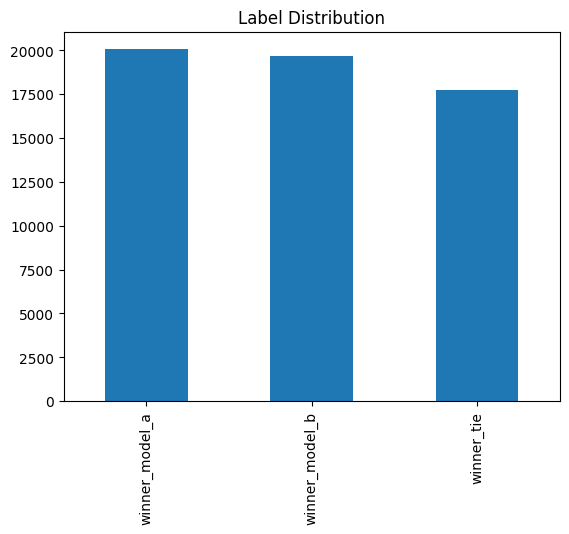

In [4]:
df[["winner_model_a", "winner_model_b", "winner_tie"]].sum().plot(kind='bar', title='Label Distribution')

array([[<Axes: title={'center': 'prompt_len'}>,
        <Axes: title={'center': 'resp_a_len'}>],
       [<Axes: title={'center': 'resp_b_len'}>, <Axes: >]], dtype=object)

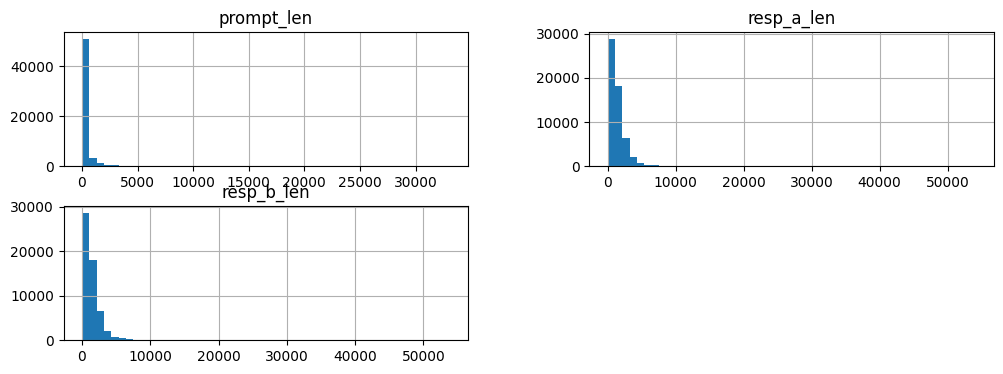

In [5]:
df[['prompt_len', 'resp_a_len', 'resp_b_len']].hist(bins=50, figsize=(12, 4))

<Axes: xlabel='preferred', ylabel='resp_a_len'>

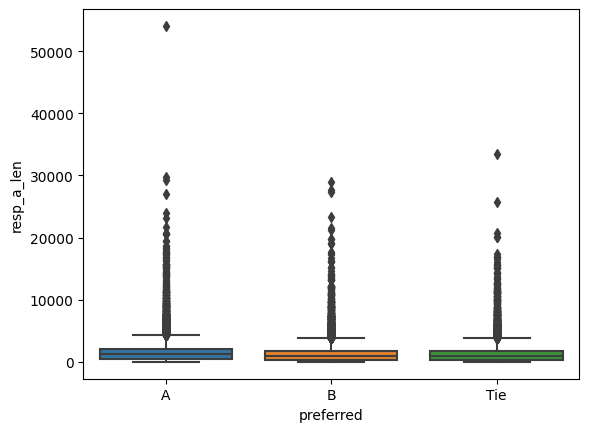

In [6]:
df['preferred'] = df['label'].map({0: 'A', 1: 'B', 2: 'Tie'})
sns.boxplot(x='preferred', y='resp_a_len', data=df)


<Axes: xlabel='preferred', ylabel='resp_b_len'>

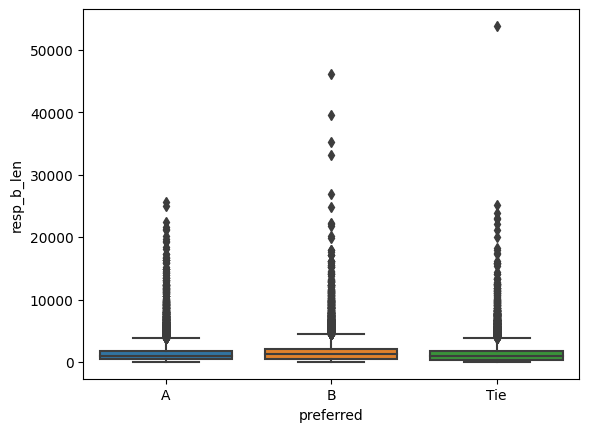

In [7]:
sns.boxplot(x='preferred', y='resp_b_len', data=df)

In [8]:
df['label'].value_counts(normalize=True)

label
0    0.349079
1    0.341911
2    0.309011
Name: proportion, dtype: float64

In [9]:
df.isnull().sum()
df['response_a'].apply(lambda x: isinstance(x, str)).value_counts()

response_a
True    57477
Name: count, dtype: int64

In [10]:
pio.renderers.default = 'iframe'

fig = px.bar(pd.concat([df["model_a"], df["model_b"]]).value_counts(),
             title="Battle Count for Each Model", text_auto=True)
fig.update_layout(xaxis_title="model", yaxis_title="Battle Count", height=400,
                  showlegend=False)
fig  

In [11]:
winners = pd.Series(
    data=pd.concat([
        df.loc[df['winner_model_a'] == 1, 'model_a'],
        df.loc[df['winner_model_b'] == 1, 'model_b']
    ])
)

win_counts = winners.value_counts()

fig = px.bar(
    win_counts,
    title="Win Count for Each Model",
    text_auto=True
)
fig.update_layout(
    xaxis_title="Model",
    yaxis_title="Win Count",
    height=400,
    showlegend=False
)

fig


# 3. Build Model

Since ML models cannot understand raw text directly, we should start off by sentence embedding(numerical representation) of the prompt + response_x.

Now we can use the 2 numerical outputs to compare how they differ (the difference) and how they are similar (the product).

In [12]:
features = ['prompt_len', 'resp_a_len', 'resp_b_len']
target = 'label'

X = df[features]
y = df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = LGBMClassifier(
    objective='multiclass',
    num_class=3,           # Because 3 classes: model_a, model_b, tie
    random_state=42,
    n_estimators=100,
    learning_rate=0.05
)

model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 45981, number of used features: 3
[LightGBM] [Info] Start training from score -1.052457
[LightGBM] [Info] Start training from score -1.073231
[LightGBM] [Info] Start training from score -1.174353


LGBMClassifier(learning_rate=0.05, num_class=3, objective='multiclass',
               random_state=42)

In [13]:
y_pred_proba = model.predict_proba(X_val)
loss = log_loss(y_val, y_pred_proba)
print(f"Validation Log Loss: {loss:.4f}")

Validation Log Loss: 1.0516
